### Generate data

In [6]:
include("all_code/code_needed.jl")
# example:
r = 3; #three communities for now
n0 = [100,100,100] #number of nodes in each community
p = 0.9 #whithin community
q = 0.1 #between communities
A,communities = generate_SBM_data(r,n0,p,q)
M = create_subnetworks(A,r,n0)
# M has 6 matrices as follows:
# 1 x x
# 2 3 x
# 4 5 6
# M[i] = the block number in the above picture

M0 = A
M1 = vcat(hcat(spzeros(M[1]),M[2]',M[4]'),hcat(M[2],spzeros(M[3]),M[5]'),hcat(M[4],M[5],spzeros(M[6])))
# M1 has the same matrix with zero matrices on the diagonal
;

### Experiment 0

In [4]:
#initialize a few things
#keeping the data as it is and running double seeded PageRank on all existing triangles

myalpha = 0.8
curM = copy(A) # the adjacency matrix of the full network

@time i1,j1,TR = find_edges_of_tris(M);
tensor_ids_sample = hcat(i1,j1)# equivalent to: unique(tensor_ids[:,1:2],dims=1)

exps = length(i1)
all_aucs = zeros(exps)
all_aucs1 = zeros(exps)
all_aucs2 = zeros(exps)
all_aucs3 = zeros(exps)
all_aucs4 = zeros(exps)
for ii = 1:exps
    # the vectors to potentially use as seed vectors
    v = spzeros(size(curM,2))
    vi = copy(v)
    vj = copy(v)
    
    rw = tensor_ids_sample[ii,:] # pick the pair to seed on
    i = rw[1]
    j = rw[2]
    jm = n0[1] + j # map back to the full network
    
    # use v to pair seed
    v[i] = 0.5
    v[jm] = 0.5
    
    # vi to single seed
    vi[i] = 1
    
    # vj to single seed
    vj[jm] = 1
    
    ism = TR[ii,:] 
    k_ids = ism.nzind # this is everything that i and jm form triangles with
    
    xrefreal = zeros(Int64,n0[3])
    xrefreal[k_ids] .= 1
    
    xsol = seeded_pagerank(curM,myalpha,v)
    xsol1 = seeded_pagerank(curM,myalpha,vi)
    xsol2 = seeded_pagerank(curM,myalpha,vj)
    
    xsol3 = xsol1.*xsol2 # "and"
    xsol4 = xsol1.+xsol2 # "or"
    
    xk = xsol[n0[1]+n0[2]+1:end] # double seed
    xk1 = xsol1[n0[1]+n0[2]+1:end] # single seed 1
    xk2 = xsol2[n0[1]+n0[2]+1:end] # single seed 2
    xk3 = xsol3[n0[1]+n0[2]+1:end] # "and"
    xk4 = xsol4[n0[1]+n0[2]+1:end] # "or"
    
    fpr,tpr,auc = calc_AUC_new(xrefreal,xk)
    fpr,tpr,auc1 = calc_AUC_new(xrefreal,xk1)
    fpr,tpr,auc2 = calc_AUC_new(xrefreal,xk2)
    fpr,tpr,auc3 = calc_AUC_new(xrefreal,xk3)
    fpr,tpr,auc4 = calc_AUC_new(xrefreal,xk4)
    
    all_aucs[ii] = auc
    all_aucs1[ii] = auc1
    all_aucs2[ii] = auc2
    all_aucs3[ii] = auc3
    all_aucs4[ii] = auc4
end

  1.286748 seconds (1.84 M allocations: 90.295 MiB, 4.20% gc time)


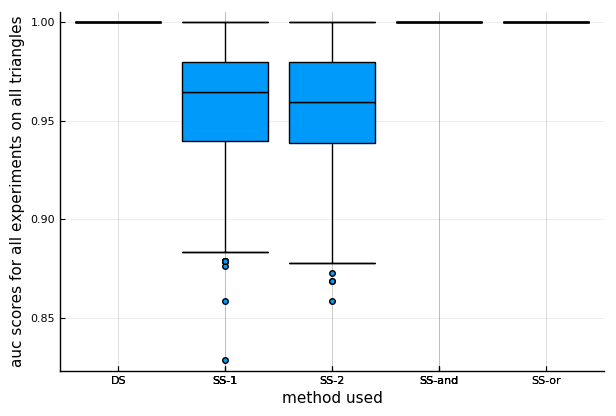

In [5]:
# plot the distributions of the auc scores
pyplot()
aucvals = hcat(all_aucs,all_aucs1,all_aucs2,all_aucs3,all_aucs4)
aucvals = aucvals'[:]
boxplot(["DS","SS-1","SS-2","SS-and","SS-or"],aucvals,leg=false)
xlabel!("method used")
ylabel!("auc scores for all experiments on all triangles")
# savefig("exp0-sanity-synthetic-1000-b-w.pdf") b = between communitites, w = within community
savefig("exp0-sanity-synthetic-1000-1-9.pdf")

### Experiment 1 (wedges) [drop one side of the triangles]

In [7]:
#initialize a few things
myalpha = 0.8
curM = copy(A) #copy(M0)

@time i1,j1,TR = find_edges_of_tris(M);
@time tensor_ids_sample = hcat(i1,j1)# equivalent to: unique(tensor_ids[:,1:2],dims=1) 
exps = size(tensor_ids_sample,1) #100

all_aucs_new = zeros(exps,4)
for ii = 1:exps
    v = spzeros(size(curM,2)) #pairseed vector
    vi = copy(v)
    vj = copy(v)
    
    rw = tensor_ids_sample[ii,:]
    i = rw[1]
    j = rw[2]
    jm = n0[1] + j
    
    v[i] = 0.5
    v[jm] = 0.5
    vi[i] = 1
    vj[jm] = 1
    
    Mc = copy(curM) # just to drop some info
    
    ism = TR[ii,:]
    k_ids = ism.nzind
    xrefreal = zeros(Int64,n0[3])
    xrefreal[k_ids] .= 1
    
    k_ids_mapped = k_ids .+ n0[1] .+ n0[2]
    
    # current triangles are [i,j]-k ==> drop all (i,k) connections
    Mc[i,k_ids_mapped] .= 0
    Mc[k_ids_mapped,i] .= 0
#     Mc[jm,k_ids_mapped] .= 0
#     Mc[k_ids_mapped,jm] .= 0
    
    xsol = seeded_pagerank(Mc,myalpha,v)
    xsol1 = seeded_pagerank(Mc,myalpha,vi)
    xsol2 = seeded_pagerank(Mc,myalpha,vj)
    
    xsol3 = xsol1.*xsol2 
    xsol4 = xsol1.+xsol2
    
    xk = xsol[n0[1]+n0[2]+1:end]#DS
    xk1 = xsol1[n0[1]+n0[2]+1:end]#SS
    #xk2 = xsol2[n0[1]+n0[2]+1:end]
    xk3 = xsol3[n0[1]+n0[2]+1:end]#SS-A
    xk4 = xsol4[n0[1]+n0[2]+1:end]#SS-O
    
    fpr,tpr,auc = calc_AUC_new(xrefreal,xk)
    fpr,tpr,auc1 = calc_AUC_new(xrefreal,xk1)
    fpr,tpr,auc2 = calc_AUC_new(xrefreal,xk3)
    fpr,tpr,auc3 = calc_AUC_new(xrefreal,xk4)
    all_aucs_new[ii,:] = [auc,auc1,auc2,auc3]
end

  0.004102 seconds (4.46 k allocations: 1.681 MiB)
  0.000016 seconds (8 allocations: 10.188 KiB)


In [8]:
all_aucs_new

625×4 Array{Float64,2}:
 0.848485  0.474747   0.858586  0.848485
 0.918367  0.5        0.918367  0.918367
 0.862245  0.326531   0.862245  0.862245
 1.0       0.858586   1.0       1.0     
 0.969697  0.646465   0.939394  0.969697
 0.79798   0.191919   0.79798   0.79798 
 0.878788  0.323232   0.89899   0.878788
 1.0       0.919192   1.0       1.0     
 1.0       0.919192   1.0       1.0     
 0.892857  0.142857   0.877551  0.892857
 0.892857  0.443878   0.892857  0.892857
 0.949495  0.838384   0.959596  0.949495
 0.808081  0.333333   0.818182  0.808081
 ⋮                                      
 0.888889  0.232323   0.878788  0.888889
 0.785714  0.392857   0.841837  0.785714
 0.933673  0.556122   0.954082  0.933673
 0.909091  0.505051   0.929293  0.909091
 0.969388  0.663265   0.979592  0.969388
 0.984694  0.760204   0.984694  0.984694
 0.888889  0.313131   0.89899   0.888889
 0.858586  0.0909091  0.858586  0.858586
 0.858586  0.030303   0.858586  0.858586
 0.979798  0.727273   0.989899  0

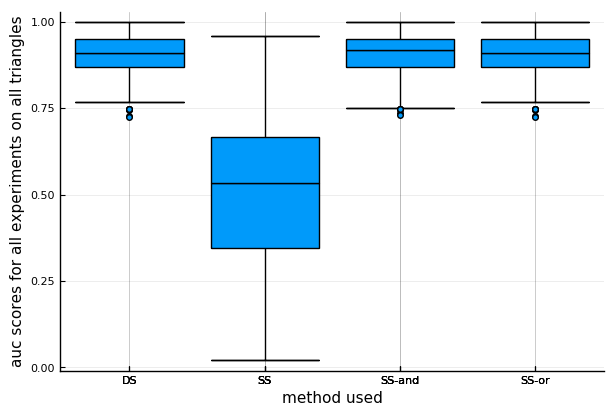

In [9]:
pyplot()
aucvals = all_aucs_new'[:]
boxplot(["DS","SS","SS-and","SS-or"],aucvals, legend = false)
xlabel!("method used")
ylabel!("auc scores for all experiments on all triangles")
savefig("exp1-synthetic-wedges-1-9.pdf")

### Experiment 2 (edges)

In [10]:
#initialize a few things
myalpha = 0.8
curM = copy(M0) #copy(M0)

@time i1,j1,TR = find_edges_of_tris(M);
tensor_ids_sample = hcat(i1,j1)# equivalent to: unique(tensor_ids[:,1:2],dims=1) 
exps = size(tensor_ids_sample,1) #100
all_aucs_new = zeros(exps,5)
for ii = 1:exps
    v = spzeros(size(curM,2))
    vi = copy(v)
    vj = copy(v)
    
    rw = tensor_ids_sample[ii,:]
    i = rw[1]
    j = rw[2]
    jm = n0[1] + j
    
    v[i] = 0.5
    v[jm] = 0.5
    vi[i] = 1
    vj[jm] = 1
    
    Mc = copy(curM)
    
    ism = TR[ii,:]
    k_ids = ism.nzind
    
    xrefreal = zeros(Int64,n0[3])
    xrefreal[k_ids] .= 1
    k_ids_mapped = k_ids .+ n0[1] .+ n0[2]
    
    Mc[i,k_ids_mapped] .= 0
    Mc[k_ids_mapped,i] .= 0
    Mc[jm,k_ids_mapped] .= 0
    Mc[k_ids_mapped,jm] .= 0
    
    xsol = seeded_pagerank(Mc,myalpha,v)
    xsol1 = seeded_pagerank(Mc,myalpha,vi)
    xsol2 = seeded_pagerank(Mc,myalpha,vj)
    
    xsol3 = xsol1.*xsol2 
    xsol4 = xsol1.+xsol2
    
    xk = xsol[n0[1]+n0[2]+1:end]#DS
    xk1 = xsol1[n0[1]+n0[2]+1:end]#SS
    xk2 = xsol2[n0[1]+n0[2]+1:end]
    xk3 = xsol3[n0[1]+n0[2]+1:end]#SS-A
    xk4 = xsol4[n0[1]+n0[2]+1:end]#SS-O
    
    fpr,tpr,auc = calc_AUC_new(xrefreal,xk)
    fpr,tpr,auc1 = calc_AUC_new(xrefreal,xk1)
    fpr,tpr,auc2 = calc_AUC_new(xrefreal,xk2)
    fpr,tpr,auc3 = calc_AUC_new(xrefreal,xk3)
    fpr,tpr,auc4 = calc_AUC_new(xrefreal,xk4)
    all_aucs_new[ii,:] = [auc,auc1,auc2,auc3,auc4]
end

  0.004024 seconds (4.46 k allocations: 1.681 MiB)


In [11]:
all_aucs_new

100×5 Array{Float64,2}:
 0.262626   0.40404   0.191919   0.262626   0.262626 
 0.428571   0.5       0.433673   0.433673   0.428571 
 0.219388   0.295918  0.183673   0.22449    0.219388 
 0.757576   0.858586  0.858586   0.757576   0.757576 
 0.535354   0.606061  0.59596    0.535354   0.535354 
 0.131313   0.131313  0.151515   0.131313   0.131313 
 0.141414   0.262626  0.0606061  0.131313   0.141414 
 0.878788   0.919192  0.939394   0.878788   0.878788 
 0.878788   0.919192  0.939394   0.878788   0.878788 
 0.183673   0.117347  0.367347   0.188776   0.183673 
 0.382653   0.392857  0.433673   0.382653   0.382653 
 0.676768   0.818182  0.636364   0.676768   0.676768 
 0.151515   0.262626  0.131313   0.141414   0.151515 
 ⋮                                                   
 0.306122   0.346939  0.331633   0.306122   0.306122 
 0.464286   0.5       0.5        0.464286   0.464286 
 0.69697    0.808081  0.707071   0.69697    0.69697  
 0.707071   0.808081  0.69697    0.707071   0.707071 
 0.7

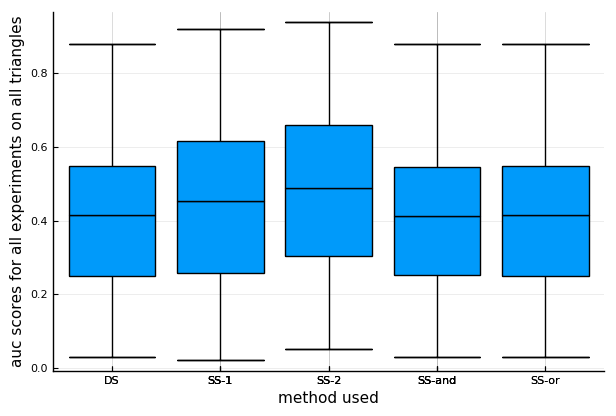

In [12]:
pyplot()
aucvals = all_aucs_new'[:]
boxplot(["DS","SS-1","SS-2","SS-and","SS-or"],aucvals, legend = false)
xlabel!("method used")
ylabel!("auc scores for all experiments on all triangles")
savefig("exp2-synthetic-edges-1-9.pdf")


## Putting it all together

In [74]:
# function SBM_double_seed_idea(
#         community_sizes::Vector{Int64}, #community sizes for SBM
#         p::Float64, #within community connection probability
#         q::Float64, #between communities
#         triangles::String, #can be "triangle","wedge", or "edge"
#         percentage_of_experiments::Float64, #0.5 to run a random set of half of the experiments, 1.0 for all
#         myalpha::Float64 #PageRank's alpha
#     )

SBM_double_seed_idea (generic function with 2 methods)

In [7]:
all_aucs_new = SBM_double_seed_idea(
    [100,100,100],
    0.9,
    0.1,
    "wedge",#"edge","triangle"
    0.25,
    0.8);

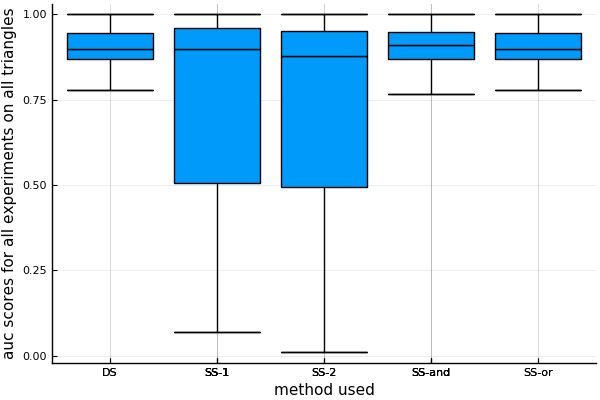

In [8]:
pyplot()
aucvals = all_aucs_new'[:]
boxplot(["DS","SS-1","SS-2","SS-and","SS-or"],aucvals, legend = false)
xlabel!("method used")
ylabel!("auc scores for all experiments on all triangles")